###**ATOC4500 Data Science Lab: Application Lab #3: Intro to Machine Learning with Meteorological Station Data**
###last updated: March 8, 2022
**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

LEARNING GOALS:
1. Use k-means clustering as an example of unsupervised (grouping events into different categories) machine learning
2. Become familiar with the limits and applicability of K-means clustering to detect the seasons in Colorado
3. Assess sensitivity of K-means to standardization, changing the input data, and number of clusters.

In this lab, we will use [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to classify weather data into different clusters. Why would we cluster weather observations?  We already know which observations are in which season by looking at the date. So... we could hypothesize each cluster might look like a season.  But we all know that in Colorado: *a day in February sometimes feels like summer and a day in September can feel like winter.*  We often have multiple seasons in a single week... So this could be quite fun to see how the algorithm decides how to cluster Colorado weather data and assign each time to a "season". :) <br>

**STEP 1: Import packages and functions we will use**

In [1]:
import pandas as pd
import numpy as np
import datetime
#import datetime as dt
from google.colab import files

from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

##Introducing your data... The Christman Dataset## 
i.e., 2016 weather observations from Christman Field, Fort Collins, Colorado.
The data are in a comma-delimited file called al3_christman_2016.csv. The data were munged by Prof. Libby Barnes at Colorado State University.

**STEP 2: Read in the Data and Look At It, Add a variable in the dataframe for the season**

In [2]:
### upload file al3_christman_2016.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving al3_christman_2016.csv to al3_christman_2016.csv
User uploaded file "al3_christman_2016.csv" with length 519276 bytes


In [3]:
df = pd.read_csv("al3_christman_2016.csv")
## transform the day column into a readable date. Can only run once successfully.
df['day'] = [datetime.date.fromordinal(day+693594) for day in df['day']] 
#print(df['day'])
## preview data (also through df.head() & df.tail())
df

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_mb,SOLIN_Wm2,Prec_inches
0,2016-01-01,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0
1,2016-01-01,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0
2,2016-01-01,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0
3,2016-01-01,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0
4,2016-01-01,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2016-12-31,0.791667,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0.0
8780,2016-12-31,0.833333,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0.0
8781,2016-12-31,0.875000,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0.0
8782,2016-12-31,0.916667,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0.0


In [4]:
print(f'How many days are in this dataset? {df.day.nunique()}')

How many days are in this dataset? 366


In [5]:
## add a new variable called "season" to the pandas dataframe called df
## this variable contains the season defined traditionally based on the month: 
## DJF=winter, MAM=spring, JJA=summer, SON=fall

#1) use a dictionary to define seasons from months
#define the seasons as DJF=winter=1, MAM=spring=2, JJA=summer=3, SON=fall=4

seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}
## define a function to assign seasons to months using the dictionary
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

## apply the function season to one time in my dataset as a sanity check
#print(df['day'][5000].month)
#print(season(df['day'][5000].month))

## apply it to all times in my dataset - check
#for month in pd.DatetimeIndex(df['day']).month[-5000:-4890]:
#  print(season(month))

# 2) apply the function season to all times in my dataset
df['season']=[season(month) for month in pd.DatetimeIndex(df['day']).month]

#check random value values
#df['season'][5000]

## check the data frame to see if there is a new variable called "season"
df

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_mb,SOLIN_Wm2,Prec_inches,season
0,2016-01-01,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0,1
1,2016-01-01,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0,1
2,2016-01-01,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0,1
3,2016-01-01,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0,1
4,2016-01-01,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2016-12-31,0.791667,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0.0,1
8780,2016-12-31,0.833333,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0.0,1
8781,2016-12-31,0.875000,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0.0,1
8782,2016-12-31,0.916667,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0.0,1


**STEP 3: Select Data To Use, Convert data into a Numpy Array, Look at data again!**

In [6]:
#### select the time

##Only select noons, or when day_fraction is equal to 0.5.
noondf = df[df.hour==0.5] ## noon

### tinker later (code that you may want to "borrow" later in this notebook)
##noondf = df[hour==0.25] ## what time is this??
#noondf = df # try selecting all data instead of just noon data

In [9]:
## Select variables of interest. Aside variables are called "features" by some in the ML world.

included_cols = ['temp_F','RH','dewtemp_F','wind_mph','wind_dir',
                 'windgust','windgust_dir','pres_mb','SOLIN_Wm2','Prec_inches'] # original input

### tinker later (code that you may want to "borrow" later in the lab)
#included_cols = ['temp_F','RH','dewtemp_F','wind_mph','windgust','pres_mb','Prec_inches'] 
#included_cols = ['temp_F','wind_mph'] # try only using temp_F and wind_mph
#included_cols = ['RH','wind_mph'] # try only using RH and wind_mph

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data = noondf.loc[:, noondf.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data -- should be (366,10) (days, variable)
print(f'Your data should be 366 observations over 10 variables: {np.shape(data)}')
print(f'Your data includes the following variables: {included_cols}')
print(f'# of variables: {len(included_cols)}')

Your data should be 366 observations over 10 variables: (366, 10)
Your data includes the following variables: ['temp_F', 'RH', 'dewtemp_F', 'wind_mph', 'wind_dir', 'windgust', 'windgust_dir', 'pres_mb', 'SOLIN_Wm2', 'Prec_inches']
# of variables: 10


In [10]:
### option to check out quick plots of your data...
### say yes first time through - double check your input, ALWAYS.
quickplot = 'no'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(data)[1]):
    plt.plot(data[:,i]);
    plt.title(included_cols[i])
    plt.show()

**STEP 4: Rescale your data to have unit variance, Look at your data again!**. *Why do you need to rescale? Because clustering among features depends on distance, we need to scale all of our features so that all features have equal variance. We don't want the clustering to be dominated by the feature with the largest variance...*

In [11]:
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.whiten.html
#"Before running k-means, it is beneficial to rescale each feature dimension of the observation 
#set by its standard deviation (i.e. “whiten” it - as in “white noise” where each frequency has equal power). 
#Each feature is divided by its standard deviation across all observations to give it unit variance."
scaled_data = whiten(data) # sci-kit learn's function to standardize data in the clustering toolbox
#scaled_data = data.copy() # uncomment to NOT whiten, but still enable this notebook to run without modifications

## Check that you end up with the same shape as the original data...
print(f'LOOK AT YOUR DATA: shape should be (days, variable), more specifically (366,10): {np.shape(scaled_data)}')

print('mean of each variable')
print(np.mean(scaled_data,axis=0))
print('standard deviation of each variable')
print(np.std(scaled_data,axis=0))

LOOK AT YOUR DATA: shape should be (days, variable), more specifically (366,10): (366, 10)
mean of each variable
[3.08126841e+00 2.07186702e+00 1.94726665e+00 1.54064165e+00
 1.80370097e+00 1.82644739e+00 1.76102996e+00 1.40370093e+02
 2.31275140e+00 1.09089270e-01]
standard deviation of each variable
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


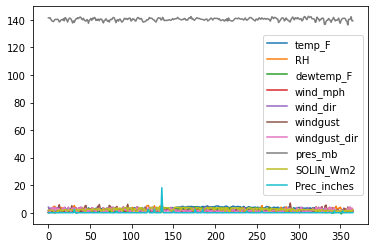

In [12]:
## option to check out quick plots of your data... always take this option.
## note: we did not remove the mean...
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(scaled_data)[1]):
    plt.plot(scaled_data[:,i],label=included_cols[i]);
    ## check what happens when you uncomment the two lines below
    #plt.title(included_cols[i])
    #plt.show()
  plt.legend()

**STEP 5: Use K-means clustering to look for patterns in the data**

In [14]:
## select the number of clusters (i.e., here the number of seasons you want to try to identify using the weather data)
NO_CLUSTERS = 4 # default is 4 for testing the hypothesis the clusters will separate into winter, fall, spring, summer

## do the clustering, return centroids (i.e., Coordinates of cluster centers.)
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)

**STEP 6: Visualize your results**. What is the cluster assigned to each time? 

In [15]:
## find an index (idx) that is the label for each value in your dataset (i.e, each day at noon in 2016)
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html
idx, _ = vq(scaled_data,centroids) # vq returns cluster idx for each observation

## add 1 so that idx is also 1-based like df['season']
idx=idx+1

print('Print the cluster idx for each day of the year:') 
print(idx) # prints K-mean's season label for each day in the year

Print the cluster idx for each day of the year:
[3 2 2 2 2 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 4 2 2 3 4 2 2 2 4 3 3 3 3 4 2 2 3
 3 3 3 4 2 2 3 4 4 2 2 4 2 2 2 4 4 2 2 2 2 2 4 2 4 2 2 2 2 4 2 2 2 2 2 4 4
 4 4 3 3 4 2 4 4 4 2 2 3 2 2 2 4 4 4 2 2 1 4 2 2 2 1 2 3 1 1 1 3 4 3 3 2 2
 1 1 2 4 1 4 3 3 3 3 3 2 1 1 1 1 3 3 1 4 2 1 1 3 3 3 3 1 1 1 1 1 1 1 1 2 4
 2 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 1 1 2 1 3 1 1 1
 1 1 1 1 1 1 1 1 4 1 1 1 4 4 1 2 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 2 1 3 1 1
 1 2 1 1 1 1 3 1 2 1 1 1 1 1 2 1 1 1 2 2 3 2 2 2 4 1 3 1 3 1 4 4 2 2 2 2 2
 2 2 4 2 2 2 4 3 4 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 3 3 3 3 2 4 2 4 2 2 3 4
 4 2 2 3 3 2 4 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 3 3 3 2 4 3 3 4 2 2 3]


####**Question 1 (10 points)**: Make an timeseries plot showing the index for each day of the year.  Your y-axis should be cluster number and your x-axis should be day of the year. ####

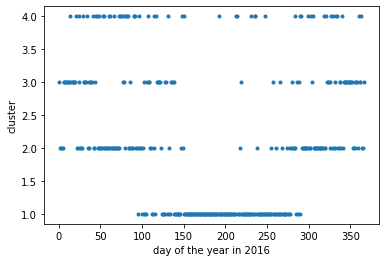

In [17]:
### put your answer to question 1 in code format here:


day=np.arange(1,367,1)
plt.plot(day,idx,'.');
plt.ylabel('cluster');
plt.xlabel('day of the year in 2016');

####**Question 2 (10 points)**: After looking at the cluster assignment for each calendar day of the year, can you associate each cluster with a date-based season?  In other words, does July all have one cluster that corresponds to summer?  Does January all have one cluster that corresponds to winter?  What have you learned from seeing the cluster assignment for each day of the calendar year? ####

**Answer**: Edit this cell and write your answer to question 2 in 2-3 complete sentences.

**STEP 7: Visualize your results**. How do the input meteorological variables associate with each individual cluster?

['temp_F', 'RH', 'dewtemp_F', 'wind_mph', 'wind_dir', 'windgust', 'windgust_dir', 'pres_mb', 'SOLIN_Wm2', 'Prec_inches']
plotting these variables: ['wind_mph', 'temp_F']
wind_mph
temp_F


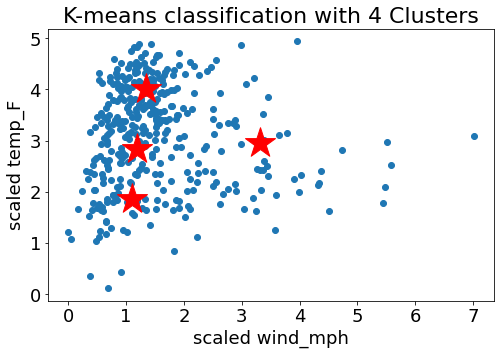

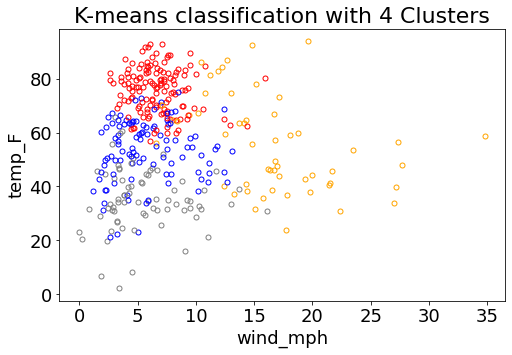

In [18]:
## Create a few xy scatter plots, where points are colored by "season" (from clustering algorithm)
## and each k-means-determined centroid is in a red stars overlaid.

### Pick any two variables that are a part of included_cols
print(included_cols)
### select two variables and put them in vars2plot - # format (x, y)
##vars2plot = ['temp_F','SOLIN_Wm2']

vars2plot = ['wind_mph','temp_F']
print(f'plotting these variables: {vars2plot}')

### other options (code to steal for later)
#vars2plot = ['RH','wind_mph']
#vars2plot = ['temp_F','pres_mb'] # format (x, y)
#vars2plot = ['temp_F','wind_mph'] # format (x, y)
#vars2plot = ['wind_mph','windgust'] # format (x, y)

data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  print(vars2plot[i])
  varidx2plot[i]=included_cols.index(vars2plot[i])
#print(varidx2plot)

### Now plot these variables as scaled values with the cluster centers
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
plt.scatter(scaled_data[:, varidx2plot[0]], scaled_data[:, varidx2plot[1]])
plt.scatter(centroids[:, varidx2plot[0]], centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('scaled '+vars2plot[0],fontsize=18);
plt.ylabel('scaled '+vars2plot[1],fontsize=18);
plt.show()

### Next plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);

####**Question 3 (10 points)**: Which meteorological variables enable the most distinct clusters to be formed?  For example, is temperature better than wind speed in differentiating between the different clusters? ####

**Answer**: Edit this cell and write your answer to question 3 in 2-3 complete sentences.

**STEP 8: Visualize your results.** Show cluster assignments for the date-based seasons using histograms.

In [19]:
#### prepare data

### check the shapes
## date-based season from the definition in the season dictionary above
season_idx=df['season'][df.hour==0.5].to_numpy()
print(season_idx.shape)
## "season" from the k-means clustering algorithm
print(idx.shape)

### find the k-means cluster value assigned for each time in each season

## find all of the times in winter, i.e., where season_idx=1
winteridx=np.nonzero(np.where(season_idx==1,1,0))
#print(winteridx) ### uncomment me to check the code
## find what values the k-means classified for this season
winter=idx[winteridx]
#print(winter)  ### uncomment me to check the code

## find all of the times in spring, i.e., where season_idx=2
springidx=np.nonzero(np.where(season_idx==2,1,0))
## find what values the k-means classified for this season
spring=idx[springidx]

## find all of the times in summer, i.e., where season_idx=3
summeridx=np.nonzero(np.where(season_idx==3,1,0))
## find what values the k-means classified for this season
summer=idx[summeridx]

## find all of the times in fall, i.e., where season_idx=4
fallidx=np.nonzero(np.where(season_idx==4,1,0))
## find what values the k-means classified for this season
fall=idx[fallidx]

(366,)
(366,)


In [20]:
## find all of the times in two seasons (code just for reference)
#transidx=np.append(np.where(season_idx==2),np.where(season_idx==4))
## find what values the k-means classified for this season
#trans=idx[transidx]

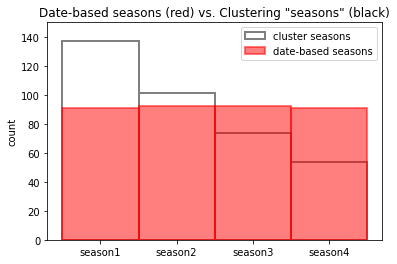

In [21]:
### Calculate and plot histogram type #1 - 
## Compare # of values in each date-based season and in each k-means cluster "season"

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

#### plot the histogram
h, mids = np.histogram(idx,bins=hist_bins);
plt.hist(idx,bins=mids,facecolor='white',edgecolor="grey",label='cluster seasons',lw=2);
plt.hist(season_idx,bins=mids,facecolor='r',edgecolor="r",label='date-based seasons',alpha=0.5,lw=2);
plt.ylabel('count')
plt.ylim(0,150)
plt.xticks(np.arange(1,4+1),labels=['season1','season2','season3','season4']);
plt.legend();
plt.title('Date-based seasons (red) vs. Clustering "seasons" (black)');

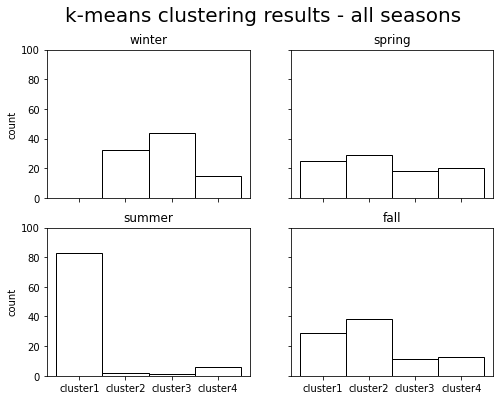

In [23]:
### Histogram Type #2 - Histograms of k-means clustering results for each season

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

## sanity check = plot the histogram of assigned clusters for winter
#h, mids = np.histogram(winter,bins=hist_bins);
#labels4xaxis=['cluster1','cluster2','cluster3','cluster4']
#plt.figure(figsize=(4,4))
#plt.hist(winter,bins=mids,facecolor='w',edgecolor="k");
#plt.xticks(np.arange(1,4+1),labels=labels4xaxis);
#plt.title('Winter');
#plt.show();

### Show all seasons using subplots
### Help with subplots: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

labels4xaxis=['','cluster1','cluster2','cluster3','cluster4']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('k-means clustering results - all seasons',fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(8)

ymax=100
h, mids = np.histogram(winter,bins=hist_bins);
ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
ax1.set_title("winter");
ax1.set_ylabel("count");
ax1.set_ylim(0,ymax)
h, mids = np.histogram(spring,bins=hist_bins);
ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
ax2.set_title("spring");
ax2.set_ylim(0,ymax)
h, mids = np.histogram(summer,bins=hist_bins);
ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
ax3.set_title("summer");
ax3.set_xticklabels(labels4xaxis);
ax3.set_ylabel("count");
ax3.set_ylim(0,ymax)
h, mids = np.histogram(fall,bins=hist_bins);
ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
ax4.set_title("fall");
ax4.set_xticklabels(labels4xaxis);
ax4.set_ylim(0,ymax)

for ax in fig.get_axes():
    ax.label_outer()

####**Question 4 (20 points)**: Using histogram 1 - How often do each of the clusters occur - and how does that distribution compare to date-based season?  Using histogram 2 - How to the cluster based vs. date-based seasons differ when you look by month?  What do you learn from comparing the histograms of the cluster-based seasons and the date-based seasons? Are the values based on the clustering analysis evenly distributed into 4 seasons?  ####

**Answer**: Edit this cell and write your answer to question 4 in 4-5 complete sentences.

####**Question 5 (10 points)**: Tell a friend who isn't enrolled in this class what you learned from this analysis.  In other words, what did clustering tell you that you think is important and easy to communicate?####

**Answer**: Edit this cell and write your answer to question 5 in 2-3 complete sentences.

##...................SAVE A COPY OF COMPLETED NOTEBOOK BEFORE YOU PROCEED..........................##

**Once the code above makes sense and you have answered all 6 questions above... It's time to choose your own adventure and start to explore this analysis further! Pick one of the options below as a group and... "Tinker!!". We recommmend you copy the code into a new notebook so that you retain this notebook for easy comparison.**. 

**Option #1: Make a copy of this notebook, rename it, and re-run the analysis... but change the code so that you use a different number of clusters (recommend to try 2 clusters, 3 clusters)**. Why did you want to change the number of clusters you are using? Does the k-means cluster gives different results when you change the number of clusters? Which number of clusters (i.e., number of seasons identified using k-means clustering) make more sense to you based on your analysis and also your experience living along the front range of Colorado? 

**Option #2: Make a copy of this notebook, rename it, and re-run the analysis...  but change the code to so that you cluster with less than the original 10 variables**. Which variables (also called "features" in machine learning lingo) are most important for defining the clusters?  What happens if you only cluster based on the wind variables? Re-run your analysis with variables that you think are most (or least!) important for defining the seasons...

**Option #3: Make a copy of this notebook, rename it, and re-run the analysis...   Recall this code selected only the data at local noon.** What happens if you run this analysis based on 6 am or 6 pm?  What happens if you run this analysis based on all times of day?

####**Question 6 (10 points)**: List all of the code changes required to implement the option you select. ####

**Answer**: Edit this cell and write your answer to question 7.

####**Question 7 (10 points)**: What has changed in your new clustering analysis? Why?  ####

**Answer**: Edit this cell and write your answer to question 8.

####**Question 8 (10 points)**: What has stayed the same in your new clustering analysis?  ####





**Answer**: Edit this cell and write your answer to question 9.

####**Question 9 (10 points)**: What has stayed the same in your new analysis?  ####


**Answer**: Edit this cell and write your answer to question 10.

## END OF APPLICATION LAB #3 - Congratulations!! ##